## Importing

In [1]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
#from run_sem_with_features import preprocess_skel
import joblib
from utils import get_point_biserial, get_binned_prediction
from utils import contain_substr
import seaborn as sns

pn.extension()


### Initialize Variables and Widgets

In [2]:

df = pd.read_csv('output/run_sem/results_corpus_entropy.csv')
df = df[~df['tag'].isna()]

df['chapter'] = df['run'].apply(lambda x: int(x[2]))
df['entropy_abs'] = df['entropy'] * np.log(df['n_event_models'])
df['config'] = df['tag'].apply(lambda tag: tag[:tag.find('grid')])
# df['number_boundaries'] = df['number_boundaries'].clip(upper=150)

available_tags = list(df['tag'].unique())
available_tags = sorted([x for x in available_tags if ('june' in x or 'july' in x)])
default_tag = available_tags[0]
available_metrics = sorted(list(df.columns))
default_metric = ['mean_pe', 'percentile', 'pearson_r', 'number_boundaries', 'epoch', 'n_event_models', 'active_event_models',
                  'entropy']
available_runs = sorted(list(df['run'].unique()))
default_run = available_runs
available_train_runs = list(df[(df['is_train'] == True)]['run'].unique())
default_train_run = available_train_runs
available_valid_runs = list(df[(df['is_train'] == False)]['run'].unique())
default_valid_run = available_valid_runs

multi_tag_select = pn.widgets.MultiSelect(name='Select 2 or 3 Tags for Comparison', value=[default_tag], options=available_tags,
                                          height=100)
multi_metric_select = pn.widgets.MultiSelect(name='Select Metrics to Visualize', value=default_metric, options=available_metrics,
                                             height=100)
multi_run_select = pn.widgets.MultiSelect(name='Select Runs to Visualize', value=default_run, options=available_runs,
                                          height=100)
multi_train_run_select = pn.widgets.MultiSelect(name='Select train_runs to Visualize', value=default_train_run,
                                                options=available_train_runs,
                                                height=100)
multi_valid_run_select = pn.widgets.MultiSelect(name='Select valid_runs to Visualize', value=default_valid_run,
                                                options=available_valid_runs,
                                                height=100)

train_checkbox = pn.widgets.Checkbox(name='Display Train?', value=True)
valid_checkbox = pn.widgets.Checkbox(name='Display Valid?', value=False)
compare_config = pn.widgets.Checkbox(name='Compare Configs?', value=False)

hues = ['tag', 'chapter', 'run', 'config', 'is_train']
hue_select = pn.widgets.Select(name='Select Hue', options=hues, value='tag')


C:\Users\nguye\anaconda3\envs\pt-tf-37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# df = pd.read_csv('output/run_sem/results_corpus_entropy.csv')
# df = df[~df['tag'].isna()]
#
# df['chapter'] = df['run'].apply(lambda x: int(x[2]))
# df['entropy_abs'] = df['entropy'] * np.log(df['n_event_models'])
# df['config'] = df['tag'].apply(lambda tag: tag[:tag.find('grid')])
# df


In [4]:
# available_tags = list(df['tag'].unique())
# available_tags = sorted([x for x in available_tags if ('june' in x or 'july' in x)])
# available_tags

In [5]:
alfas = sorted(list(set([x.split('_')[-2] for x in available_tags])))
lmdas = sorted(list(set([x.split('_')[-1] for x in available_tags])))
configs = sorted(list(set([x[:x.find('grid')] for x in available_tags])))

multi_alfa_select = pn.widgets.MultiSelect(name='Select Alfas', value=[alfas[0]], options=alfas)
multi_lmda_select = pn.widgets.MultiSelect(name='Select Lmdas', value=[lmdas[0]], options=lmdas)
multi_config_select = pn.widgets.MultiSelect(name='Select Configs', value=[configs[0]], options=configs)


@pn.depends(multi_alfa_select, multi_lmda_select, multi_config_select)
def alfa_lmda_to_tag(multi_alfa_select, multi_lmda_select, multi_config_select):
    select_tags = []
    for alfa in multi_alfa_select:
        for lmda in multi_lmda_select:
            if float(alfa[-5:]) == float(lmda[-5:]):
                continue
            for config in multi_config_select:
                select1 = f'{alfa}_{lmda}'
                select2 = f'{config}'
                select_tags.extend([t for t in available_tags if select1 in t and select2 in t])
    multi_tag_select.value = sorted(select_tags)

### Define necessary functions for PE



In [6]:
import param


class ActionExample(param.Parameterized):
    """
    Demonstrates how to use param.Action to trigger an update.
    """

    #     number = param.Number(default=0)

    action = param.Action(lambda x: x.param.trigger('action'), label='Update Data!')

    #     @param.depends('action')
    #     def get_number(self):
    #         return self.number
    def get_df_select(self):
        print(f'Update data: \n'
              f'tags={multi_tag_select.value} \n'
              f'runs={multi_run_select.value}')
        all_runs = multi_train_run_select.value + multi_valid_run_select.value
        df_select = df[(df['tag'].isin(multi_tag_select.value)) & (df['run'].isin(all_runs))
                       & ( df['epoch'] > 50)
                       ]
        if not (train_checkbox.value and valid_checkbox.value):
            if train_checkbox.value:
                df_select = df_select[(df_select['is_train'] == True)]
            elif valid_checkbox.value:
                df_select = df_select[(df_select['is_train'] == False)]
        return df_select

    action_matrix = param.Action(lambda x: x.param.trigger('action_matrix'), label='Update Matrix pane')
    @param.depends('action_matrix')
    def matrix_visualize(self):
        # print(f'Update data: \n'
        #       f'tags={multi_tag_select.value} \n'
        #       f'runs={multi_run_select.value}')
        # all_runs = multi_train_run_select.value + multi_valid_run_select.value
        # df_select = df[(df['tag'].isin(multi_tag_select.value)) & (df['run'].isin(all_runs))
        #                & ( df['epoch'] > 50)
        #                ]
        # if not (train_checkbox.value and valid_checkbox.value):
        #     if train_checkbox.value:
        #         df_select = df_select[(df_select['is_train'] == True)]
        #     elif valid_checkbox.value:
        #         df_select = df_select[(df_select['is_train'] == False)]

        df_select = self.get_df_select()

        tags = sorted(list(df_select['tag'].unique()))
        print(f'Tags for plotting Matrix: {tags}')
        if len(tags) == 0:
            return None
        if valid_checkbox.value:
            alpha = 0.05
        else:
            alpha = 0.2
        hue = hue_select.value
        hue_order = sorted(list(df_select[hue].unique()))

        print('Plotting Matrix pane...')
        sns_plot = sns.pairplot(df_select[multi_metric_select.value + [f'{hue}']],
                                hue=f'{hue}', hue_order=hue_order, palette='bright',
                                # kind='scatter', plot_kws={'alpha': 0.2, 's': 10},
                                kind='reg', plot_kws={'scatter_kws': {'alpha': alpha, 's': 10}, 'ci': None,
                                                      'lowess': True
                                                      },
                                height=1.6)
        for lh in sns_plot._legend.legendHandles:
            lh._sizes = [100]
        fig = sns_plot.fig
        #     fig.set_size_inches(7,5)
        fig.savefig('matrix.png')
        plt.close()
        print('Done Matrix pane!')
        return fig
    
    action_pe = param.Action(lambda x: x.param.trigger('action_pe'), label='Update PE pane')
    @param.depends('action_pe')
    def plot_pe(self):
        df_select = self.get_df_select()
        tags = sorted(list(df_select['tag'].unique()))
        if len(tags) == 0:
            return None
        if valid_checkbox.value:
            alpha = 0.05
        else:
            alpha = 0.2

        fig, axes = plt.subplots(nrows=1, ncols=len(tags), figsize=(4*len(tags), 4), squeeze=False, sharex=True, sharey=True)
        fig.suptitle(f'PE across epochs for all Tags', fontsize=14)
        axes = axes.reshape((1, len(tags)))
        print('Plot PE pane...')
        for tag, ax in zip(tags, axes[0]):
            df_tag = df_select[df_select['tag'] == tag]
            sns.regplot(x="epoch", y="mean_pe", data=df_tag, ax=ax, lowess=True, scatter_kws={'alpha': alpha})
            ax.set_title(f'PE for {tag}')
        plt.close()
        print('Done PE pane!')
        return fig



action_matrix = ActionExample()

Update pane: 
tags=[] 
runs=['1.1.10_kinect', '1.1.1_kinect', '1.1.2_kinect', '1.1.3_kinect', '1.1.4_kinect', '1.1.5_kinect', '1.1.6_kinect', '1.1.7_kinect', '1.1.8_kinect', '1.1.9_kinect', '1.2.3_kinect', '1.2.4_kinect', '1.2.5_kinect', '1.2.6_kinect', '1.2.7_kinect', '1.2.8_kinect', '1.2.9_kinect', '1.3.10_kinect', '1.3.1_kinect', '1.3.3_kinect', '1.3.4_kinect', '1.3.6_kinect', '1.3.7_kinect', '1.3.8_kinect', '1.3.9_kinect', '2.2.10_kinect', '2.2.1_kinect', '2.2.2_kinect', '2.2.3_kinect', '2.2.4_kinect', '2.2.5_kinect', '2.2.6_kinect', '2.2.7_kinect', '2.2.8_kinect', '2.2.9_kinect', '2.3.1_kinect', '2.3.2_kinect', '2.3.3_kinect', '2.3.4_kinect', '2.3.5_kinect', '2.3.6_kinect', '2.3.7_kinect', '2.3.8_kinect', '2.4.10_kinect', '2.4.1_kinect', '2.4.2_kinect', '2.4.3_kinect', '2.4.4_kinect', '2.4.5_kinect', '2.4.6_kinect', '2.4.7_kinect', '2.4.8_kinect', '2.4.9_kinect', '3.1.10_kinect', '3.1.1_kinect', '3.1.2_kinect', '3.1.3_kinect', '3.1.5_kinect', '3.1.6_kinect', '3.1.7_kinect', '3.1.8

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] MultiSelect(name='Select Alfas', options=['alfa1E+00', ...], value=['alfa1E+00'])
        [1] MultiSelect(name='Select Lmdas', options=['lmda1E+00', ...], value=['lmda1E+00'])
        [2] MultiSelect(name='Select Configs', options=['july_01_pca30_k0_paralle...], value=['july_01_pca30_k0_paralle...])
    [2] Row
        [0] MultiSelect(height=100, name='Select Metrics t..., options=['active_event_models', ...], value=['mean_pe', 'percentile', ...])
        [1] ParamFunction(function)
        [2] MultiSelect(height=100, name='Select 2 or 3..., options=['july_01_pca30_k0_paralle...])
        [3] MultiSelect(height=100, name='Select train_runs t..., options=['2.4.7_kinect', ...], value=['2.4.7_kinect', ...])
        [4] MultiSelect(height=100, name='Select valid_runs t..., options=['6.2.10_kinect', ...], value=['6.2.10_kinect', ...])
    [3] Row
        [0] Button(name='Update!')
        [1] Checkbox(name='Display Train?', value=True)
        [2] Checkbox(name='Display Valid?')
        [3] Select(options=['tag', 'chapter', ...], value='tag')
    [4] ParamMethod(method)
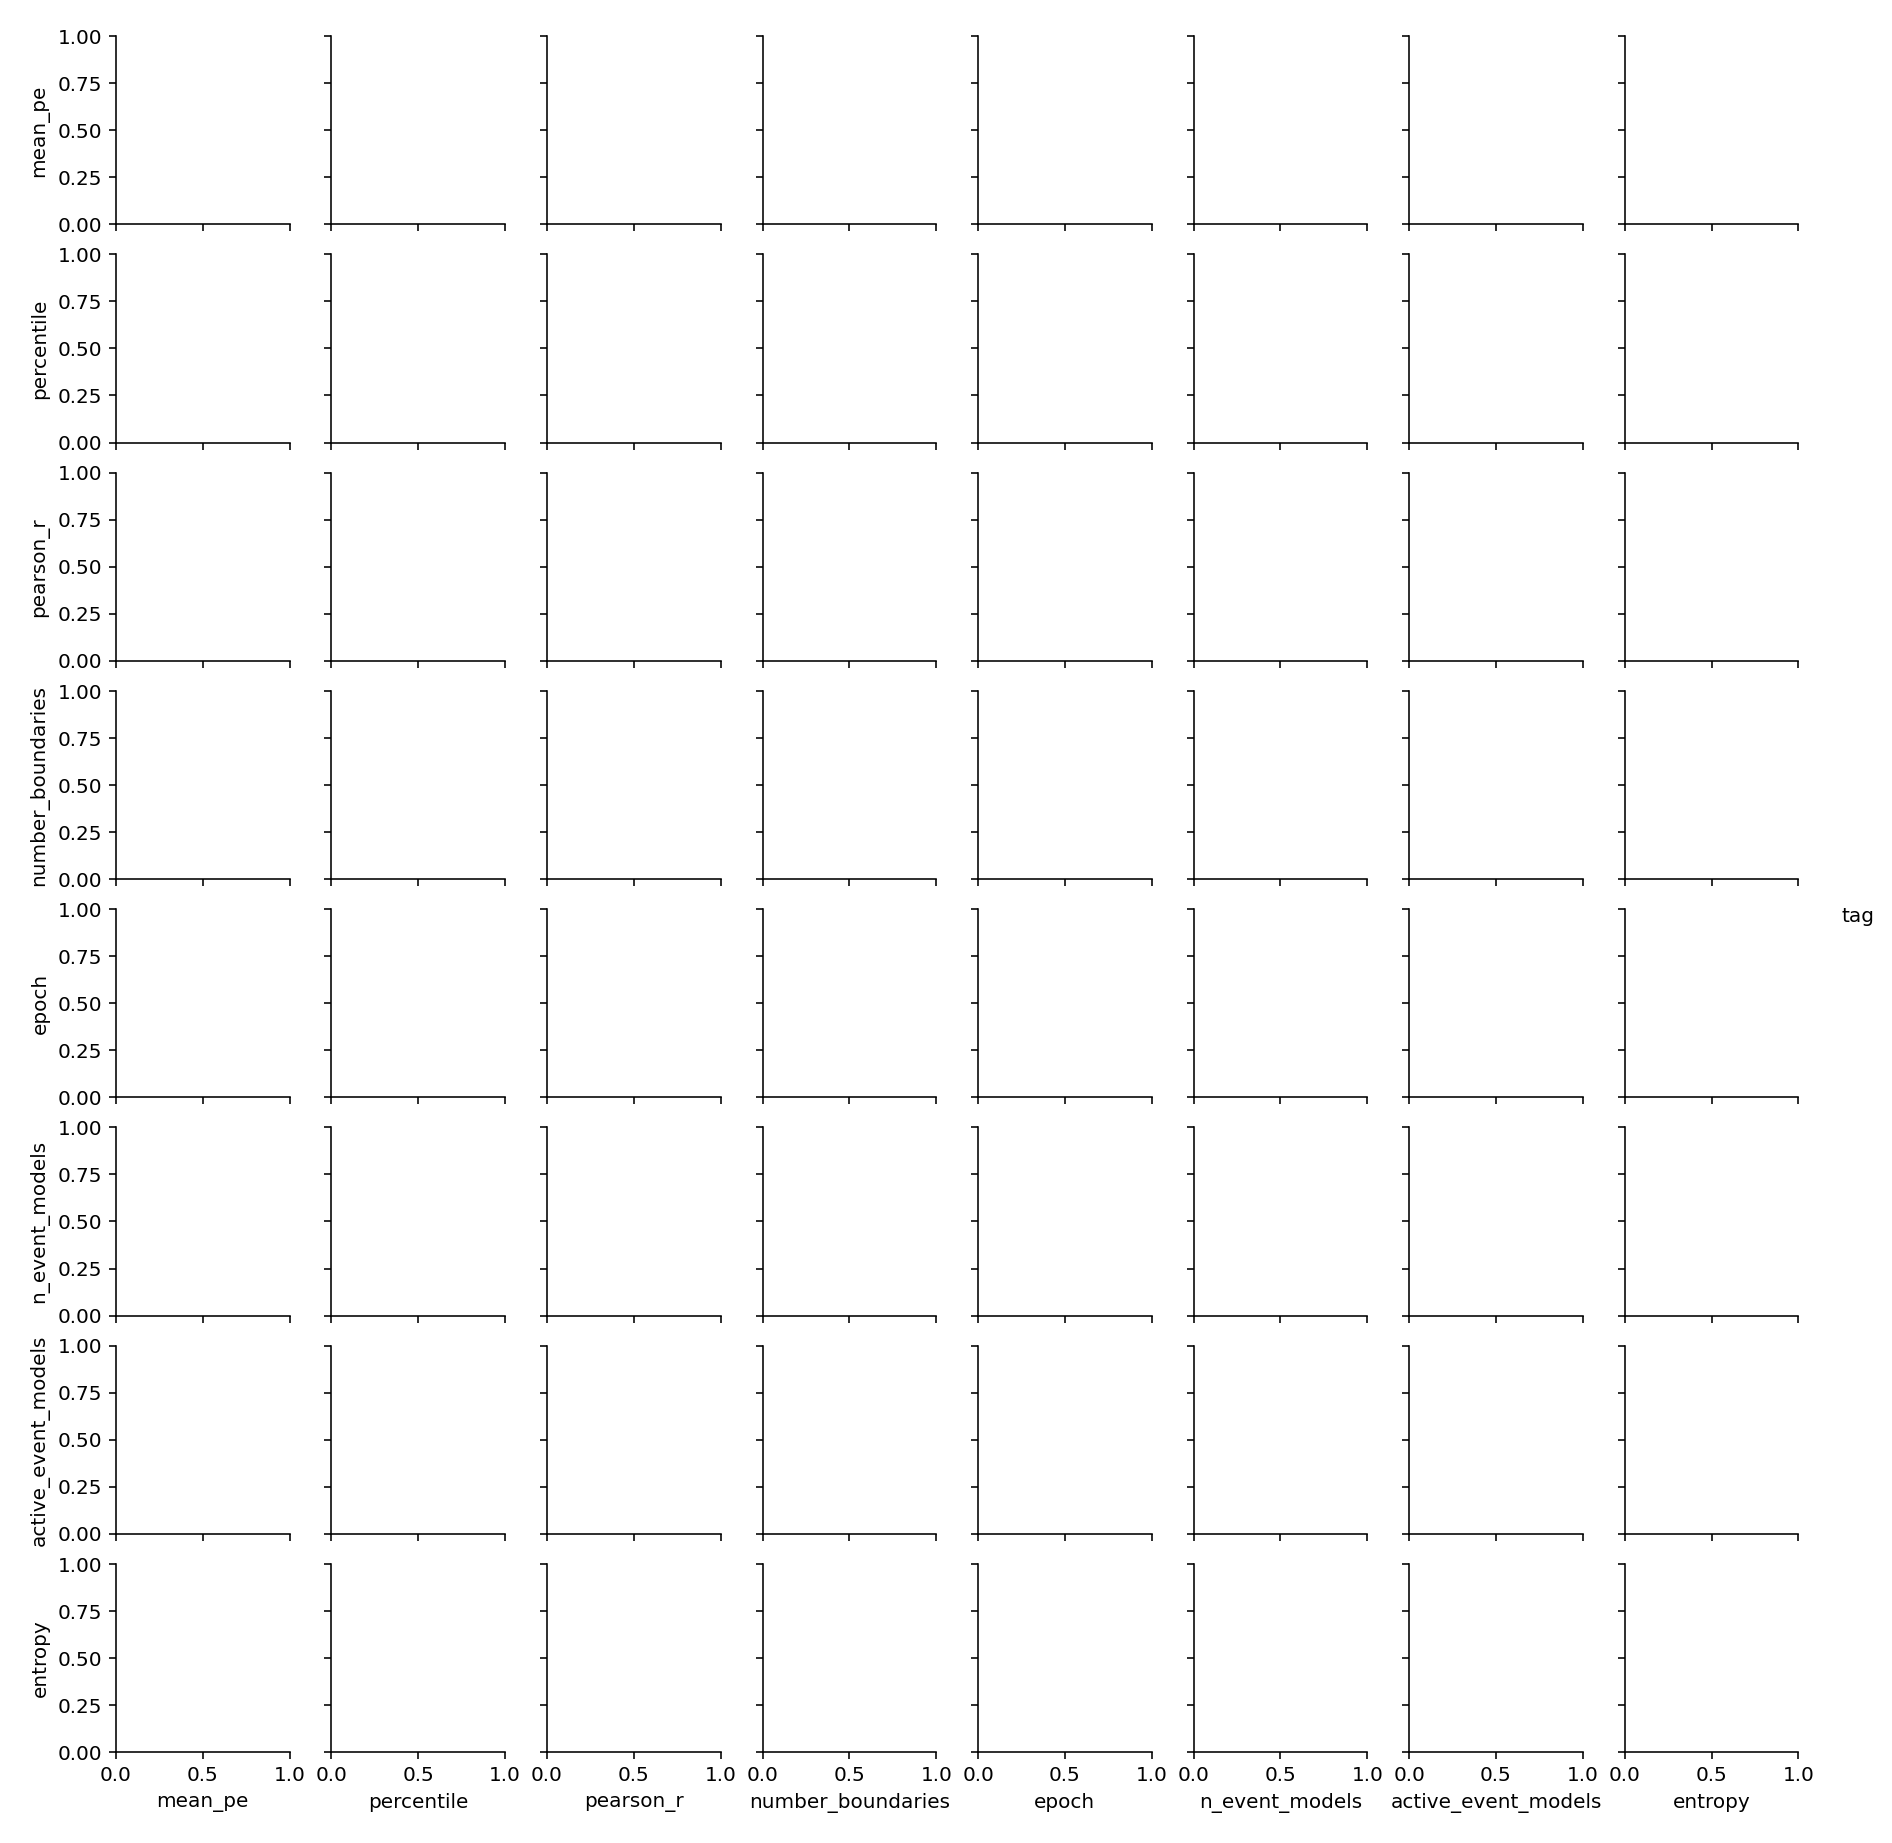

In [7]:
dashboard = pn.Column(
    pn.Row('Compare Scatter Matrices Across Configurations'),
    pn.Row(multi_alfa_select, multi_lmda_select, multi_config_select),
    pn.Row(multi_metric_select, alfa_lmda_to_tag, multi_tag_select, multi_train_run_select, multi_valid_run_select),
    pn.Row(
            # action_matrix.param.action,
            train_checkbox,
            valid_checkbox,
            hue_select),
    pn.Column(action_matrix.param.action_matrix, action_matrix.matrix_visualize),
    pn.Column(action_matrix.param.action_pe, action_matrix.plot_pe),
)

# Launch the dashboard
dashboard.servable()

In [8]:
# all_runs = multi_train_run_select.value + multi_valid_run_select.value
# df_select = df[(df['tag'].isin(['july_01_pca30_k0_parallel_grid_alfa1E+02_lmda1E+06'])) & (df['run'].isin(all_runs))]
# if not (train_checkbox.value and valid_checkbox.value):
#     if train_checkbox.value:
#         df_select = df_select[(df_select['is_train'] == True)]
#     elif valid_checkbox.value:
#         df_select = df_select[(df_select['is_train'] == False)]
#
# hue = hue_select.value
# sns_plot = sns.pairplot(df_select[multi_metric_select.value + [f'{hue}']], hue=f'{hue}', palette='bright',
#                         # kind='reg', plot_kws={'scatter_kws': {'alpha': 0.3}},
#                         kind='reg',
#                         plot_kws={'scatter_kws': {'alpha': 0.5, 's': 10}, 'ci': None},
#                         height=1.6)
# for lh in sns_plot._legend.legendHandles:
#     lh._sizes = [100]
# %matplotlib inline
# plt.show()

In [9]:
# sem_readout = pkl.load(open('output/run_sem/may_22_df60_nh5_grid_alfa1E+02_lmda5E+01/1.1.10_kinect_trimmay_22_df60_nh5_grid_alfa1E+02_lmda5E+01_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 60)[0]
# for av in active_events:
#     print(sem_readout['Sigma'][av], sem_readout['c'][av])
#
#

In [10]:
# v = sem_readout
#

In [11]:
#         df_post = pd.DataFrame(v['post'])
#         df_filtered_post = df_post.loc[:, (df_post > 1e-2).any(axis=0)]
#         sns.lineplot(data=df_filtered_post, ax=ax1)
#

In [12]:
# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt
# events = sem_readout['c'][sem_readout['c'] > 0]
# sns.distplot(range(len(events)), bins=len(events), hist_kws={"weights": events}, kde=False)
# # plt.hist(counted_data.keys(), weights=counted_data.values(), bins=range(50))
#

In [13]:
# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt
# events = sem_readout['c'][sem_readout['c'] > 0]
# sns.distplot(range(len(events)), bins=len(events), hist_kws={"weights": events}, kde=False)
# # plt.hist(counted_data.keys(), weights=counted_data.values(), bins=range(50))
#

In [14]:
# sem_readout['c'][sem_readout['c'] > 0]
#

In [15]:
# sem_readout = pkl.load(open('output/run_sem/may_22_df60_nh5_grid_alfa1E+02_lmda1E+03/1.1.10_kinect_trimmay_22_df60_nh5_grid_alfa1E+02_lmda1E+03_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 60)[0]
# for av in active_events:
#     print(sem_readout['Sigma'][av], sem_readout['c'][av])
#


In [16]:
# # checking kappa to make sure it's 0 during validation
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/1.1.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])
# print('---')
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/2.2.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])

In [17]:
# # checking kappa to make sure it's 0 during validation
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/1.1.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])
# print('---')
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/2.2.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])

In [ ]:
# # checking kappa to make sure it's 0 during validation
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/1.1.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])
# print('---')
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/2.2.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])